# Multi-Exit (or Early Exit) Neural Network Tutorial 

## 1. Introduction

- **Motivation**: The motivation of multi-exit neural networks is that we can assign a shallow network for easy task and deep network for hard task. To achieve both objective in one neural network, developers make multiple exit points in one neural network. 
- **Advantage**: The advantages of multi exit neural network are as follows:
    1. We can split the neural network in multiple nodes (or devices) and efficiently compute the result considering the task hardness. 
    2. Reducing computational cost by skipping high-level computation of neural networks. 
- **In Communication Networks** (especially for edge AI): In edge-AI networks, a hierarchical computing networks, a common method is assigning front DNN in edge devices and end DNN in cloud/edge servers. 

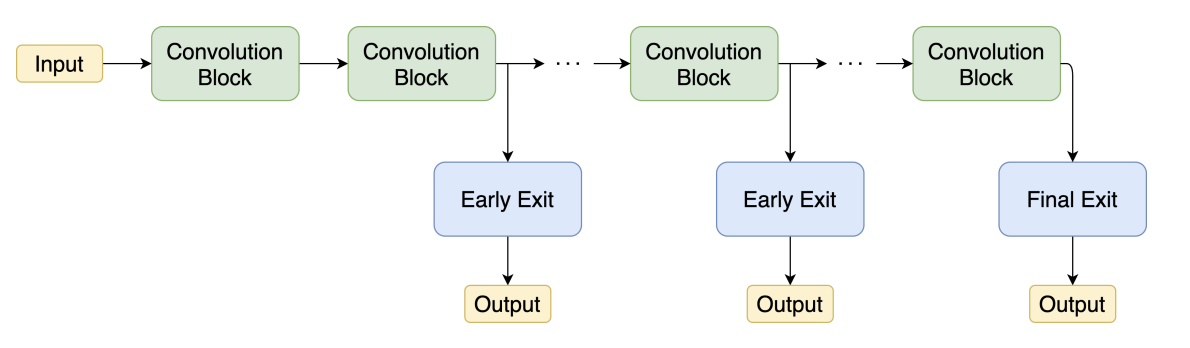

## 2. Code Example with Interpretations
A simple version of multi-exit training & inference code based on linear layers for helping your understanding. 
- Dataset: `EMNIST`
- Network: Linear layer with 6 hidden layers
- Number of Exit Points: `3`
- Exit Policy: Entropy Threshold

### 2.1. Settings

1. Here, we load required libraries and packages first.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import numpy as np
from tqdm import tqdm
device = 'cuda:0'

/home/jgjang/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Then, define a multi-exit neural network having three exit points, where the architecture is composed of Linear layers.

In [2]:
import torch.nn.functional as F

class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__()

        self.main_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            )
        
        self.main_2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            )
            
        self.main_3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            )
        self.exit_1 = nn.Sequential(
            nn.Linear(1024, num_classes)
            )
        self.exit_2 = nn.Sequential(
            nn.Linear(1024, num_classes)
            )
        self.exit_3 = nn.Sequential(
            nn.Linear(1024, num_classes)
            )
    def forward(self, x):
        x = self.main_1(x)
        o_1 = self.exit_1(x.detach())
        x = self.main_2(x)
        o_2 = self.exit_2(x.detach())
        o_3 = self.exit_3(self.main_3(x))
        return o_1, o_2, o_3

3. Set Dataloader

In [3]:
num_classes = 47
batch_size = 256
data_transform =  transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])
data_train = datasets.EMNIST(root= './DATA', train= True, split = 'balanced',
                             download = True, transform=data_transform)
data_test = datasets.EMNIST(root= './DATA', train= False, split = 'balanced',
                            download = True, transform=data_transform)
        
trainloader = torch.utils.data.DataLoader(data_train, batch_size= batch_size, 
                                          shuffle = True, num_workers=1)
testloader = torch.utils.data.DataLoader(data_test, batch_size= batch_size, 
                                         shuffle = False, num_workers=1)


### 2.2. Main code
- Loss function: $\mathcal{L} = \sum_i w_i \mathcal{L}(\hat{y}_i , y)  $, where $i$ is exit index and $\hat{y}_i$ is the output of the $i$-th exit point.
- Exit policy: If entropy of the $i$-th exit output is less than a pre-determined threshold, stop computing and get result.

In [ ]:
thr = torch.tensor([0.1, 0.5]).to(device)
def test(model):
    model.eval()
    acc_list = list()
    exit_point_list = list()
    o_acc_list = list()
    for batch_idz, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward all exit points' output
        output_1, output_2, output_3 = model(inputs)
        # Concatenate the result 
        o_output = torch.cat(
            (output_1.detach().unsqueeze(1),
            output_2.detach().unsqueeze(1),
            output_3.detach().unsqueeze(1)
            ), dim=1).softmax(dim=2)
        # Compute entroy 
        entropy = -torch.sum(o_output * torch.log(o_output+1e-5), axis=2)[:,0:2]
        # If entropy < thr --> stop
        threshold = (entropy < thr).float()
        exit_point = torch.cat( 
            (threshold[:,0:1], 
             (1-threshold[:,0:1])*threshold[:,1:2], 
             (1-threshold[:,0:1])*(1-threshold[:,1:2])   ), 
            axis=1)
        #exit_point = (exit_point == np.arange(3).reshape([1,3])) +0.0
        inference = torch.argmax(o_output, dim=2)
        correct = (inference == labels.reshape([-1,1]))
        o_correct = torch.sum((inference == labels.reshape([-1,1]))*exit_point,axis=1,keepdims=True)
        acc_list.append(correct.cpu().numpy())
        o_acc_list.append(o_correct.cpu().numpy())
        exit_point_list.append(exit_point.cpu().numpy())
    acc = np.concatenate(acc_list,axis=0)
    o_acc = np.concatenate(o_acc_list,axis=0)
    exit_point = np.concatenate(exit_point_list,axis=0)
    print(f'|Accuracy| \n 1st output is {np.mean(acc,axis=0)[0]} \n 2nd output is {np.mean(acc,axis=0)[1]} \n 3rd output is {np.mean(acc,axis=0)[2]}, \n overall is {np.mean(o_acc)} \n exit_point is {np.mean(exit_point,axis=0)}' )
    return

def main():
    # Load Paramters
    lr = 0.003 
    epoch = 15
    # Load Model
    model = DNN(num_classes = num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr =lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
    for ep in range(epoch):
        model.train()
        loss_ep = list()
        for batch_idz, (inputs, labels) in tqdm(enumerate(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            #Forwrad each exit point's output
            output_1, output_2, output_3 = model(inputs)
            # Weighted sum -> loss function
            loss = 0.33 * criterion(output_1, labels) + 0.33 * criterion(output_2, labels) + 0.33 * criterion(output_3, labels)
            loss.backward()
            optimizer.step()
            loss_ep.append(loss.detach().item())
        scheduler.step()
        print(f'{ep}-th epoch loss is {np.mean(loss_ep)}')
        if ep % 5 == 4:
            test(model)
main()

441it [00:29, 14.97it/s]

0-th epoch loss is 1.1220944080493347



441it [00:27, 16.13it/s]

1-th epoch loss is 0.6624492472396686



441it [00:27, 16.08it/s]

2-th epoch loss is 0.5849656864088408



441it [00:27, 16.21it/s]

3-th epoch loss is 0.5429896151397774



441it [00:27, 16.08it/s]

4-th epoch loss is 0.5058688315269357


|Accuracy| 
 1st output is 0.7757446808510639 
 2nd output is 0.8167553191489362 
 3rd output is 0.8227127659574468, 
 overall is 0.8238829970359802 
 exit_point is [0.27058512 0.3723936  0.35702127]


441it [00:27, 16.26it/s]

5-th epoch loss is 0.4737723158870965



410it [00:25, 16.50it/s]

#### 3. Variations


### 3.1. SkipNet: Learning Dynamic Routing in Convolutional Networks, ECCV 2018
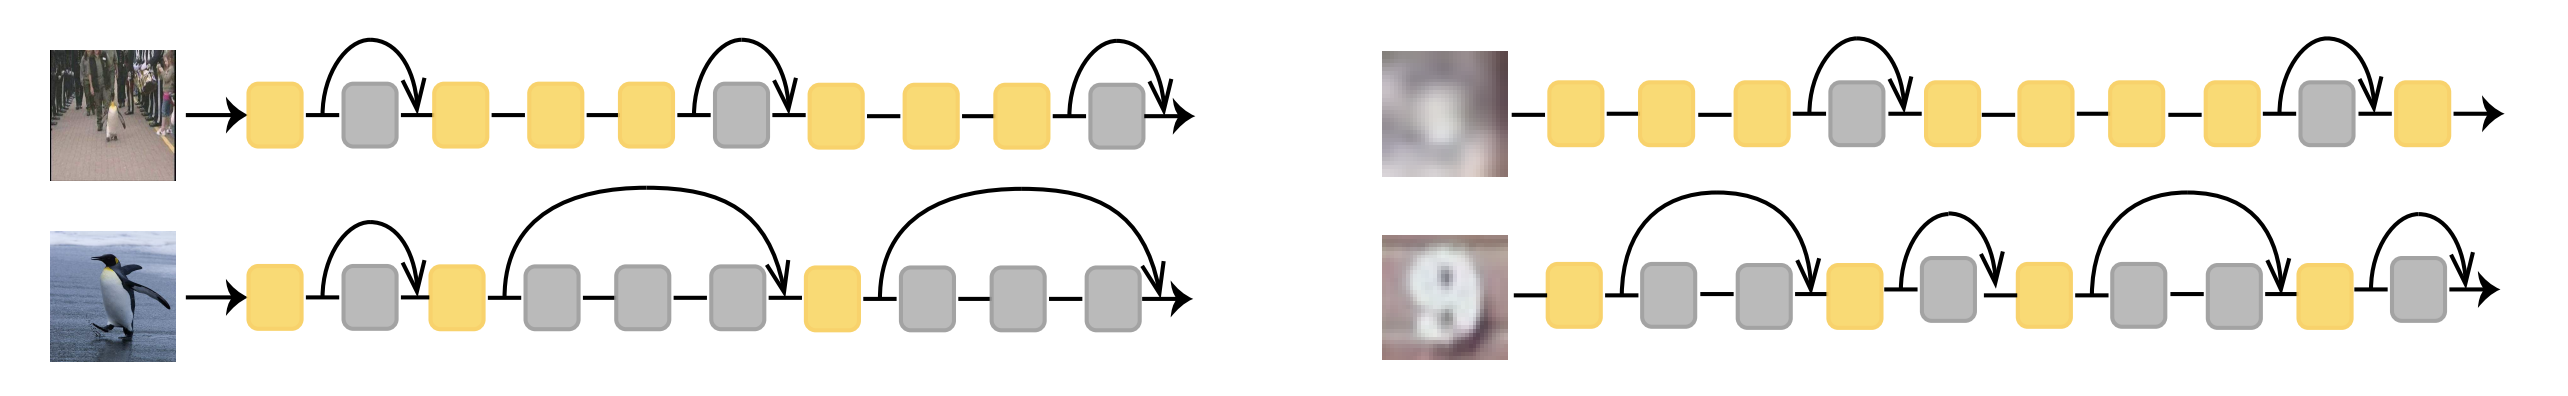

> How they can skip the neural networks?
>    - They leverage a series of gating functions to determine whether residual blocks are skiped or not. 
>    - The gating functions are trained with reinforcement learning
>    - State: image,
>    - Action: Gating values $\mathbf{g} = [g_1, ..., g_N]$
>    - Reward (for minimization): $\mathcal{L}(\hat{y}, y) - \gamma \cdot \sum {R_i}$, where $R_i$ is 0 if $i$-th gate is activate otherwise a positive value. 

### 3.2. Adaptive Token Embedding for Eff ViT, CVPR 2022


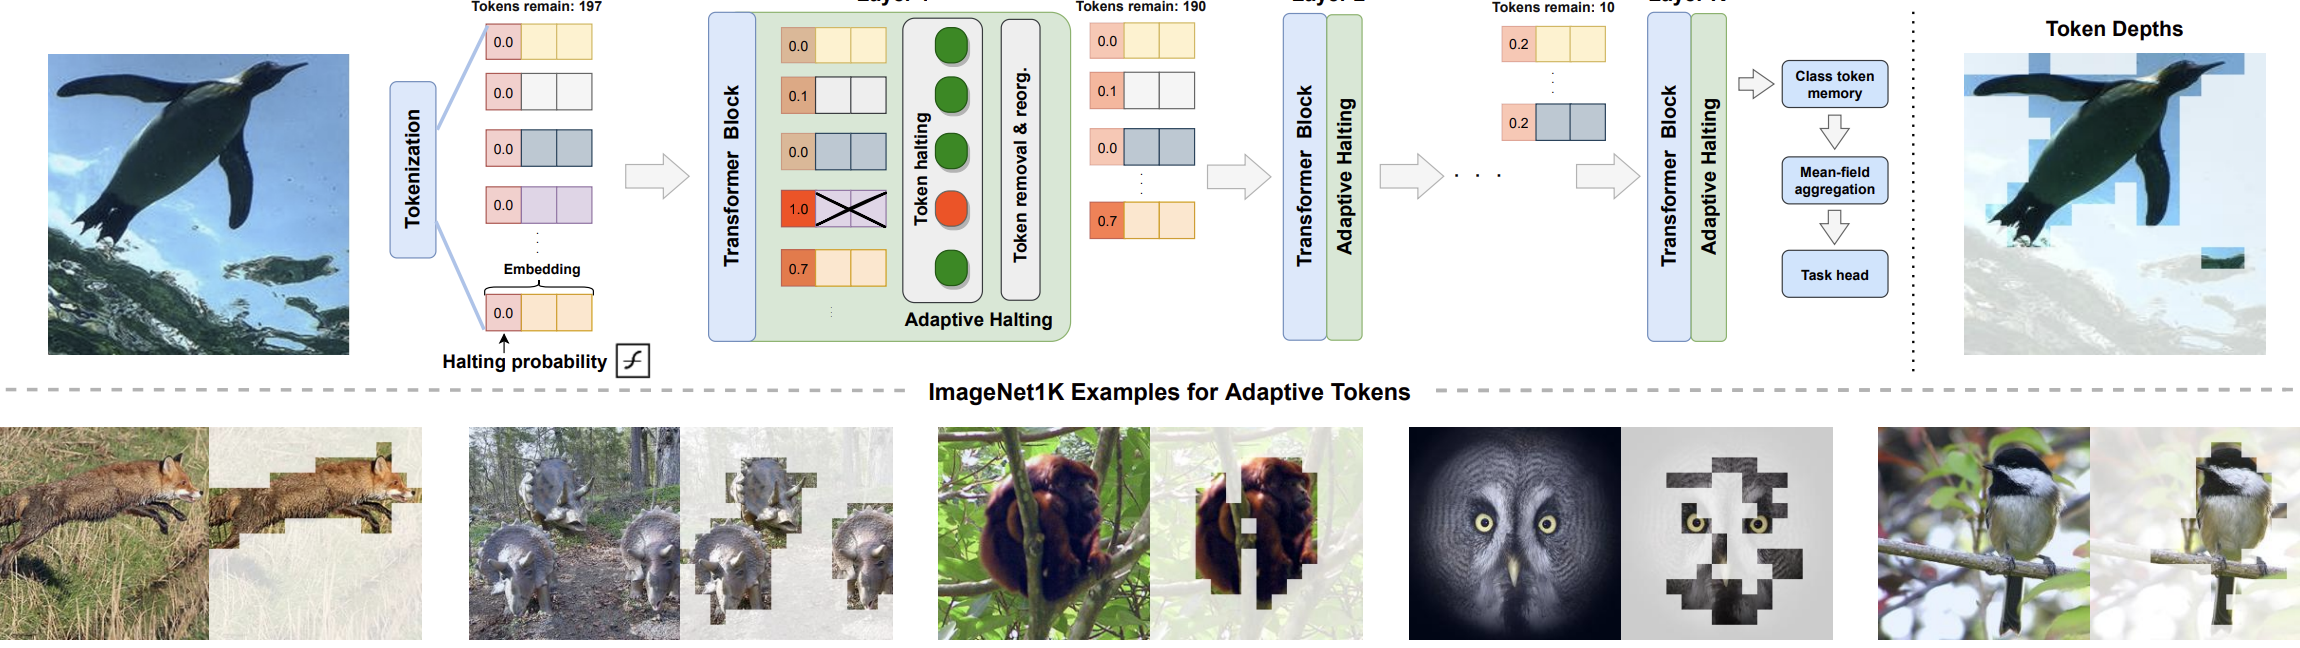

> They reduce the number of tokens used in inference adaptive to the images. How they can adaptively select tokens?
> - Embedding: An image with width $W$ and height $H$ is tokenized by $\mathbb{R}^{K\times E}$, where $K$ and $E$ mean the total number of tokens and length of embedding vectors.
> - halting design: halting probability $h_k^l = H(t_k^l)$ (function of token). If cumulative sum (for Transformer block) of halting score of a token is above given threshold, stop conducting the token. 
> - This method is similar to Skimming Transformer.


### 3.3. Poster: Adaptable Mobile Vision Systems through Multi-Exit Neural Networks, Mobisys 2022
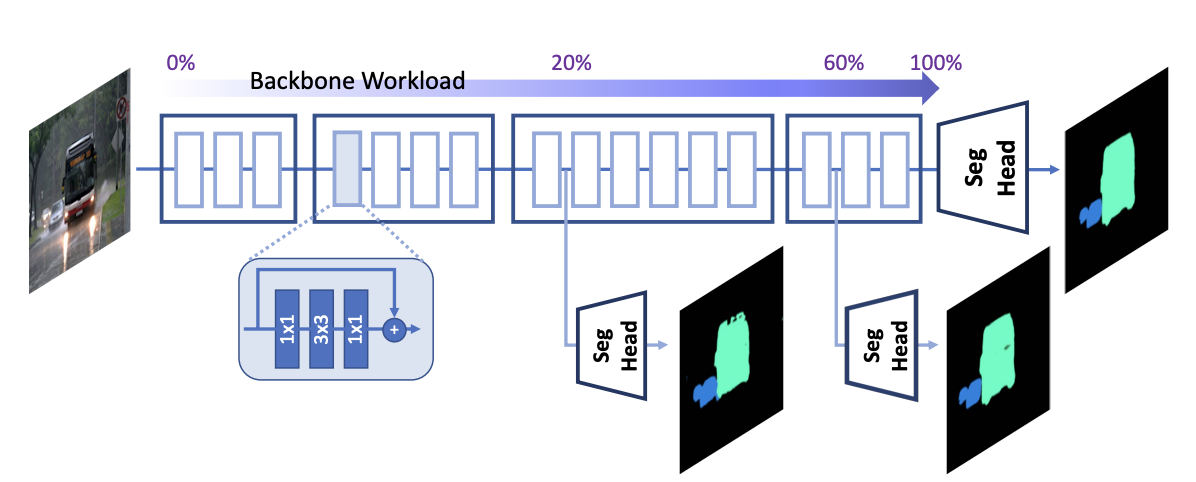

> This is the **first** multi-exit neural network application for semantic segmentation 
> - Exit Policy: Since segmentation is a set of independent classification task (consider one per pixel), they need to find a metric to summarize per-pixel confidence into a single value. Instead of naive averagin the values, they consider percentage of pixels having confidence above given threshold.